In [1]:
import numpy as np
import qutip as qt
from qutip.solver.heom import HEOMSolver, DrudeLorentzBath

import os

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def cot(z):
    return 1 / np.tan(z)

### Set up system

##### Numerical parameters

In [2]:
TLIST = np.linspace(0, 200, 1000)
MAX_STEP = 1 / 40

NUM_MATSUBARA = 3
PM_CUTOFF = [3] * (NUM_MATSUBARA + 2)

HEOM_CUTOFF = 6

##### System parameters

In [3]:
# Phys Rev Res. 5, 013181 (2023) -- Fig. 8, "fast drive"
V = 1
BETA = 10 / V
GAMMA = 1e-2 * V
LAMBDA = 1e-4 * V

TAU_P = np.pi / (2 * V)
DELTA_T = 10 / V
TAU = DELTA_T + TAU_P

##### Define system

In [4]:
def f(t):
    return V * (np.mod(t, TAU) >= DELTA_T)

Hs = qt.QobjEvo([qt.sigmax(), f])
Q = qt.sigmaz()

psi0 = (qt.basis(2,1) + qt.basis(2,0)) / np.sqrt(2)
rho0 = qt.ket2dm(psi0)

### HEOM Calculation

In [5]:
HEOM_OPTIONS = {'store_states': False,
                'method': 'vern9',
                'rtol': 1e-12, 'atol': 1e-12,
                'max_step': MAX_STEP, 'nsteps': 1500,
                'progress_bar': 'tqdm'}

In [6]:
bath = DrudeLorentzBath(Q, LAMBDA, GAMMA, 1 / BETA, NUM_MATSUBARA)
solver = HEOMSolver(Hs, bath, HEOM_CUTOFF, options=HEOM_OPTIONS)
heomsol = solver.run(rho0, TLIST, e_ops=[qt.sigmax()])

  0%|          | 0/999 [00:00<?, ?it/s]

In [7]:
# Solution with dynamical decoupling turned off
solver_noDD = HEOMSolver(0 * qt.sigmax(), bath, HEOM_CUTOFF,
                         options=HEOM_OPTIONS)
heomsol_noDD = solver_noDD.run(rho0, TLIST, e_ops=[qt.sigmax()])

  0%|          | 0/999 [00:00<?, ?it/s]

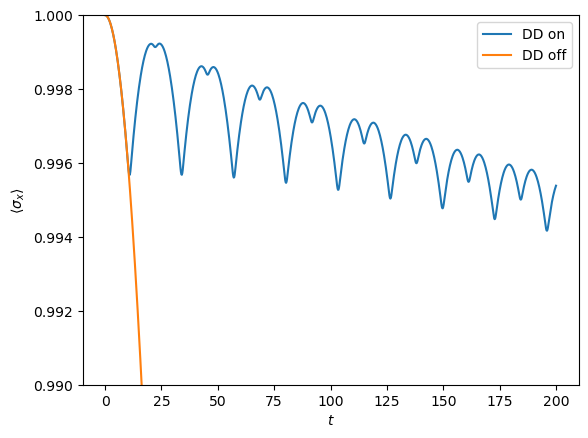

In [8]:
plt.plot(TLIST, heomsol.expect[0], label='DD on')
plt.plot(TLIST, heomsol_noDD.expect[0], label='DD off')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle \sigma_x \rangle$')
plt.ylim((0.99, 1))
plt.legend()
plt.show()

### Pseudomodes

In [9]:
PM_OPTIONS = {'normalize_output': False, 'store_states': False,
              'max_step': MAX_STEP,
              'progress_bar': 'tqdm'}

In [10]:
PM_IDENTITY = qt.tensor(*[qt.qeye(c) for c in PM_CUTOFF])

def setup_pms(Omega):
    # Omega: regularization parameter

    Hs_ = Hs & PM_IDENTITY
    Q_ = Q & PM_IDENTITY

    pseudomode_info = []  # Omega_n, Gamma_n, lambda_n (all temps are 0)

    # resonant pseudomodes
    a0 = LAMBDA * GAMMA * (cot(BETA * GAMMA / 2) - 1j)
    pseudomode_info.append(
        ((GAMMA - Omega) / 2j, GAMMA + Omega, np.sqrt(a0)))
    pseudomode_info.append(
        ((Omega - GAMMA) / 2j, GAMMA + Omega, np.sqrt(np.conj(a0))))

    # matsubara modes
    for k in range(1, NUM_MATSUBARA + 1):
        nu_k = 2 * np.pi * k / BETA
        a_k = 4 * LAMBDA * GAMMA * nu_k / BETA / (nu_k**2 - GAMMA**2)
        pseudomode_info.append((0, 2 * nu_k, np.sqrt(a_k)))

    # build up total hamiltonian, initial state, lindblad ops, rates
    H_ = Hs_
    rho0_ = rho0
    lindblad_ops = []
    rates = []

    for i, (W, G, lam) in enumerate(pseudomode_info):
        identities_before = [
            qt.qeye(2),
            *[qt.qeye(c) for j, c in enumerate(PM_CUTOFF) if j < i]]
        identities_after = [qt.qeye(c)
                            for j, c in enumerate(PM_CUTOFF) if j > i]
        create = qt.tensor(*identities_before, qt.create(PM_CUTOFF[i]),
                            *identities_after)
        destroy = qt.tensor(*identities_before, qt.destroy(PM_CUTOFF[i]),
                            *identities_after)

        H_ += W * create * destroy + lam * Q_ * (create + destroy)
        lindblad_ops.extend([destroy])
        rates.extend([G])
        rho0_ = rho0_ & qt.fock_dm(PM_CUTOFF[i])
    
    return H_, rho0_, lindblad_ops, rates

In [11]:
# the following functions will be 'e-ops'

def negativity(t, state):
    state.check_herm()
    pt = qt.partial_transpose(state, [1] + ([0] * (NUM_MATSUBARA + 2)))
    return (pt.norm(norm='tr') - 1) / 2

def base_negativity(t, state):
#    state.check_herm()  # not necessary if `negativity` is called first
    return (state.norm(norm='tr') - 1) / 2

def quantum_mutual_information(t, state):
#    state.check_herm()
    return qt.entropy_mutual(state, [0], list(range(1, NUM_MATSUBARA + 3)))

def product_distance(t, state):
#    state.check_herm()
    rhoA = qt.ptrace(state, [0])
    rhoB = qt.ptrace(state, list(range(1, NUM_MATSUBARA + 3)))
    return (state - (rhoA & rhoB)).norm()

In [12]:
pmsol = {5: None, 15: None, 50: None}

for Omega in pmsol.keys():
    path = f"../example2-{Omega}"
    if os.path.isfile(path + '.qu'):
        pmsol[Omega] = qt.qload(path)
        continue

    print(f"Integrating pseudo-Lindblad equation for Omega={Omega}")
    H_, rho0_, lindblad_ops, rates = setup_pms(Omega)
    liouvillian = -1j * qt.spre(H_) + 1j * qt.spost(H_)
    for L, gamma in zip(lindblad_ops, rates):
        LdL = L.dag() * L
        liouvillian += gamma * (qt.sprepost(L, L.dag()) - .5 * qt.spre(LdL) - .5 * qt.spost(LdL))

    result = qt.mesolve(liouvillian, rho0_, TLIST, options=PM_OPTIONS,
                        e_ops=[qt.sigmax() & PM_IDENTITY,
                               negativity,
                               base_negativity,
                               quantum_mutual_information,
                               product_distance])
    pmsol[Omega] = result
    result.options._feedback = None # qutip bug workaround
    qt.qsave(result, path)

##### Experiment: correlation functions

In [14]:
Omega = 15
TLIST2 = np.linspace(0, 100, 25)

H_, rho0_, lindblad_ops, rates = setup_pms(Omega)
liouvillian = -1j * qt.spre(H_) + 1j * qt.spost(H_)
for L, gamma in zip(lindblad_ops, rates):
    LdL = L.dag() * L
    liouvillian += gamma * (qt.sprepost(L, L.dag()) - .5 * qt.spre(LdL) - .5 * qt.spost(LdL))

In [ ]:
rho_of_t = qt.mesolve(liouvillian, rho0_, TLIST2,
                      options={**PM_OPTIONS, 'store_states': True})

In [ ]:
result = {}
sx_ = qt.sigmax() & PM_IDENTITY

for t1, rho_t1 in zip(TLIST2, rho_of_t.states):
    remaining_tlist = TLIST2[TLIST2 >= t1]
    print(f"t1 = {t1}, computing {len(remaining_tlist)} points")
    if len(remaining_tlist) == 1:
        result[(t1, t1)] = (sx_ * sx_ * rho_t1).tr()
        continue

    tmp = qt.mesolve(liouvillian, sx_ * rho_t1, remaining_tlist,
                     options={**PM_OPTIONS, 'store_states': True})
    for t2, tmp_res in zip(remaining_tlist, tmp.states):
        result[(t1, t2)] = (sx_ * tmp_res).tr()

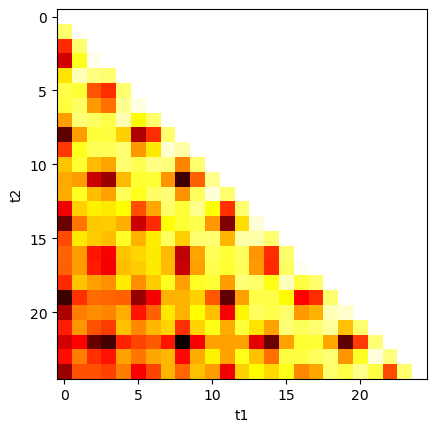

In [ ]:
plot_data = []

for t2 in TLIST2:
    row = []
    for t1 in TLIST2:
        row.append(result.get((t1,t2), 1))
    plot_data.append(row)

plt.imshow(np.abs(plot_data), cmap='hot', interpolation='nearest')
plt.xlabel("t1")
plt.ylabel("t2")
plt.show()

### Plots

In [15]:
from mpl_setup import ORANGE, SKY_BLUE, YELLOW, BLUE, VERMILLION, GRAY  # noqa: E402

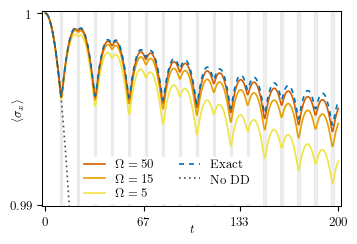

In [23]:
fig, ax = plt.subplots()

l3, = ax.plot(TLIST, pmsol[5].expect[0], color=YELLOW, label=r'$\Omega = 5$')
l2, = ax.plot(TLIST, pmsol[15].expect[0], color=ORANGE, label=r'$\Omega = 15$')
l1, = ax.plot(TLIST, pmsol[50].expect[0], color=VERMILLION, label=r'$\Omega = 50$')
l4, = ax.plot(TLIST, np.zeros_like(TLIST), color='white', label=' ') # for legend layout
l5, = ax.plot(TLIST, heomsol.expect[0], '--', color=BLUE, label='Exact')
l6, = ax.plot(TLIST, heomsol_noDD.expect[0], ':', color=GRAY, label='No DD')

for n in range((int)(TLIST[-1] / TAU)):
    ax.axvspan(n * TAU + DELTA_T, (n + 1) * TAU, color=GRAY, alpha=0.08, zorder=0)

ax.set_xlim((-2, 202))
ax.set_xlabel(r'$t$', labelpad=-3)
ax.set_xticks([0, 67, 133, 200], labels=[r'$0$', r'$67$', r'$133$', r'$200$'])

ax.set_ylim((0.9899, 1.0001))
ax.set_ylabel(r'$\langle \sigma_x \rangle$', labelpad=-10)
ax.set_yticks([0.99, 1], labels=[r'$0.99$', r'$1$'])

ax.legend(handles=[l1, l2, l3, l5, l6], loc=(0.13, 0.02), ncols=2, frameon=True, fancybox=False, framealpha=1, edgecolor="white")

plt.savefig('../ex2_time_evo.pdf')
plt.show()

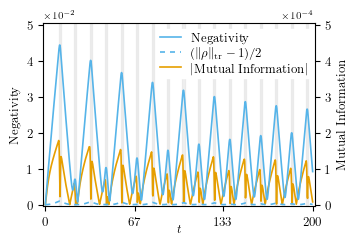

In [24]:
sol = pmsol[50]

fig, ax = plt.subplots()

ax.plot(TLIST, sol.expect[1], color=SKY_BLUE, label='Negativity', zorder=2)
ax.plot(TLIST, sol.expect[2], '--', color=SKY_BLUE, label=r'$(\lVert \rho \rVert_{\text{tr}} - 1) / 2$', zorder=3)
#ax.plot(TLIST, sol.expect[4] / 2, '--', color=ORANGE, label='Product Dist.')
ax.plot(TLIST, np.abs(sol.expect[3]) * 100, color=ORANGE, label=r'$\lvert \text{Mutual Information} \rvert$', zorder=1)

for n in range((int)(TLIST[-1] / TAU)):
    ax.axvspan(n * TAU + DELTA_T, (n + 1) * TAU, color=GRAY, alpha=0.08, zorder=0)

ax.set_xlim((-2, 202))
ax.set_xlabel(r'$t$', labelpad=-3)
ax.set_xticks([0, 67, 133, 200], labels=[r'$0$', r'$67$', r'$133$', r'$200$'])

ax.set_ylim((-0.0005, 0.0505))
ax.set_ylabel('Negativity')
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], labels=[r'$0$', r'$1$', r'$2$', r'$3$', r'$4$', r'$5$'])

right_axis = ax.twinx()
right_axis.set_ylim((-0.0005, 0.0505))
right_axis.set_ylabel('Mutual Information')
right_axis.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05], labels=[r'$0$', r'$1$', r'$2$', r'$3$', r'$4$', r'$5$'])

top_axis = ax.twiny()
top_axis.set_xlim((-2, 202))
top_axis.set_xticks([])
top_axis.xaxis.set_minor_locator(mticker.FixedLocator([11, 189]))
top_axis.xaxis.set_minor_formatter(mticker.FixedFormatter([r'\scriptsize $\times 10^{-2}$', r'\scriptsize $\times 10^{-4}$']))
top_axis.tick_params('x', which='minor', pad=0, top=False)

ax.legend(loc=(0.42, 0.7), ncols=1, frameon=True, fancybox=False, framealpha=1, edgecolor="white")

plt.savefig('../ex2_entanglement.pdf')
plt.show()